In [3]:
from models import model_paths

model_paths

{'fast': '/vol/bitbucket/bl1821/dorado-1.0.0-linux-x64/bin/dna_r10.4.1_e8.2_400bps_fast@v5.0.0',
 'hac': '/vol/bitbucket/bl1821/dorado-1.0.0-linux-x64/bin/dna_r10.4.1_e8.2_400bps_hac@v5.0.0',
 'sup': '/vol/bitbucket/bl1821/dorado-1.0.0-linux-x64/bin/dna_r10.4.1_e8.2_400bps_sup@v5.0.0'}

In [5]:
# Obtain model sizes

import subprocess

for speed, path in model_paths.items():
  result = subprocess.run(['du', '-sh', path], stdout=subprocess.PIPE, text=True, check=True)
  print(speed, result.stdout.split()[0])

fast 2.1M
hac 26M
sup 313M


In [6]:
# Total parameters

import os
import torch

for speed, path in model_paths.items():
    total = 0
    files = [file for file in os.listdir(path) if file.endswith('.tensor')]
    for file in files:
        module = torch.jit.load(os.path.join(path, file))
        for param in module.parameters():
            total += param.numel()
    print(speed, total)

fast 427728
hac 6425328
sup 78718162


In [14]:
import os
import subprocess
import torch
from collections import defaultdict
from IPython.display import display, Markdown


def get_model_size(path):
  result = subprocess.run(['du', '-sh', path], stdout=subprocess.PIPE, text=True, check=True)
  return result.stdout.split()[0]


def get_model_param_count(path):
  total = 0
  for file in os.listdir(path):
    if file.endswith(".tensor"):
      module = torch.jit.load(os.path.join(path, file))
      for param in module.parameters():
        total += param.numel()
  return total


def categorize_tensor_file(fname):
  """Categorize based on filename across SUP/HAC/FAST models."""
  if "weight" in fname:
    if fname.startswith("conv.") or fname.endswith(".conv.weight.tensor") or fname.startswith(tuple(f"{i}.conv" for i in range(10))):
      return "Conv Layers"
    elif ".rnn.weight_ih_l0.tensor" in fname or ".rnn.weight_hh_l0.tensor" in fname:
      return "RNN Layers"
    elif ".ff.fc1.weight.tensor" in fname or ".ff.fc2.weight.tensor" in fname:
      return "FF Layers"
    elif ".self_attn.Wqkv.weight.tensor" in fname or ".self_attn.out_proj.weight.tensor" in fname:
      return "Self-Attention Layers"
    elif fname == "upsample.linear.weight.tensor":
      return "Upsample Layer"
    elif fname == "crf.linear.weight.tensor":
      return "CRF Layer"
    elif fname.endswith("linear.weight.tensor"):
      return "Linear Layers"
    else:
      return "Other Weight Tensors"
  return None


def profile_models(model_paths):
  results = []

  for name, path in model_paths.items():
    metrics = defaultdict(int)
    size = get_model_size(path)
    total_params = 0

    for fname in os.listdir(path):
      if not fname.endswith(".tensor"):
        continue

      fpath = os.path.join(path, fname)
      try:
        module = torch.jit.load(fpath)
        for param in module.parameters():
          count = param.numel()
          total_params += count
          category = categorize_tensor_file(fname)
          print(fname, category)
          if category:
            metrics[category] += 1
      except Exception as e:
        print(f"Failed to load {fname} in {name}: {e}")

    results.append({
      "Model": name,
      "Size": size,
      "Parameters": f"{total_params:,}",
      "Conv": metrics["Conv Layers"],
      "RNN": metrics["RNN Layers"],
      "FF": metrics["FF Layers"],
      "Self-Attn": metrics["Self-Attention Layers"],
      "Linear": metrics["Linear Layers"],
      "Upsample": metrics["Upsample Layer"],
      "CRF": metrics["CRF Layer"],
      "Other": metrics["Other Weight Tensors"],
    })

  # Markdown output
  header = (
    "| Model | Size | Parameters | Conv | RNN | FF | Self-Attn | Linear | Upsample | CRF | Other |\n"
    "|-------|------|------------|------|-----|----|------------|--------|----------|-----|--------|"
  )
  rows = [
    f"| `{r['Model']}` | {r['Size']} | {r['Parameters']} | {r['Conv']} | {r['RNN']} | "
    f"{r['FF']} | {r['Self-Attn']} | {r['Linear']} | {r['Upsample']} | {r['CRF']} | {r['Other']} |"
    for r in results
  ]
  display(Markdown("\n".join([header] + rows)))
  return results

summary = profile_models(model_paths)


8.rnn.bias_ih_l0.tensor None
0.conv.weight.tensor Conv Layers
8.rnn.weight_ih_l0.tensor RNN Layers
6.rnn.weight_hh_l0.tensor RNN Layers
4.rnn.bias_ih_l0.tensor None
4.rnn.weight_ih_l0.tensor RNN Layers
9.linear.weight.tensor Linear Layers
7.rnn.bias_hh_l0.tensor None
2.conv.weight.tensor Conv Layers
7.rnn.weight_ih_l0.tensor RNN Layers
5.rnn.bias_ih_l0.tensor None
5.rnn.weight_hh_l0.tensor RNN Layers
6.rnn.bias_hh_l0.tensor None
5.rnn.weight_ih_l0.tensor RNN Layers
6.rnn.bias_ih_l0.tensor None
7.rnn.weight_hh_l0.tensor RNN Layers
5.rnn.bias_hh_l0.tensor None
4.rnn.weight_hh_l0.tensor RNN Layers
2.conv.bias.tensor None
7.rnn.bias_ih_l0.tensor None
6.rnn.weight_ih_l0.tensor RNN Layers
0.conv.bias.tensor None
8.rnn.weight_hh_l0.tensor RNN Layers
8.rnn.bias_hh_l0.tensor None
1.conv.weight.tensor Conv Layers
1.conv.bias.tensor None
4.rnn.bias_hh_l0.tensor None
1.conv.weight.tensor Conv Layers
8.rnn.weight_hh_l0.tensor RNN Layers
5.rnn.bias_hh_l0.tensor None
6.rnn.weight_ih_l0.tensor RNN Lay

| Model | Size | Parameters | Conv | RNN | FF | Self-Attn | Linear | Upsample | CRF | Other |
|-------|------|------------|------|-----|----|------------|--------|----------|-----|--------|
| `fast` | 2.1M | 427,728 | 3 | 10 | 0 | 0 | 1 | 0 | 0 | 0 |
| `hac` | 26M | 6,425,328 | 3 | 10 | 0 | 0 | 1 | 0 | 0 | 0 |
| `sup` | 313M | 78,718,162 | 5 | 0 | 36 | 36 | 0 | 1 | 1 | 36 |

In [4]:
import os
import shutil
import torch
from IPython.display import display, Markdown

def profile_dorado_model(model_dir):
  entries = []
  summary_data = []

  for fname in sorted(os.listdir(model_dir)):
    if not fname.endswith(".tensor"):
      continue

    fpath = os.path.join(model_dir, fname)
    try:
      mod = torch.jit.load(fpath)
      state = mod.state_dict()

      if len(state) != 1:
        print(f"Skipping {fname}: multiple tensors found.")
        continue

      name, tensor = next(iter(state.items()))
      shape = tuple(tensor.shape)
      size = tensor.numel()

      entries.append((fname, shape, size))
      summary_data.append({
        "file": fname,
        "shape": shape,
        "num_params": size,
      })

    except Exception as e:
      print(f"Error loading {fname}: {e}")

  # Generate markdown table (no sparsity)
  header = "| File | Shape | # Params |\n|------|--------|----------|"
  rows = [
    f"| `{name}` | `{shape}` | `{size}` |"
    for name, shape, size in entries
  ]
  total_params = sum(e[2] for e in entries)

  summary = f"\n**Total Parameters:** `{total_params:,}`"
  print("\n".join([header] + rows + [summary]))
  return summary_data

source_dir = "/vol/bitbucket/bl1821/dorado-1.0.0-linux-x64/bin/dna_r10.4.1_e8.2_400bps_sup@v5.0.0"
summary = profile_dorado_model(source_dir)

| File | Shape | # Params |
|------|--------|----------|
| `conv.0.conv.bias.tensor` | `(64,)` | `64` |
| `conv.0.conv.weight.tensor` | `(64, 1, 5)` | `320` |
| `conv.1.conv.bias.tensor` | `(64,)` | `64` |
| `conv.1.conv.weight.tensor` | `(64, 64, 5)` | `20480` |
| `conv.2.conv.bias.tensor` | `(128,)` | `128` |
| `conv.2.conv.weight.tensor` | `(128, 64, 9)` | `73728` |
| `conv.3.conv.bias.tensor` | `(128,)` | `128` |
| `conv.3.conv.weight.tensor` | `(128, 128, 9)` | `147456` |
| `conv.4.conv.bias.tensor` | `(512,)` | `512` |
| `conv.4.conv.weight.tensor` | `(512, 128, 5)` | `327680` |
| `crf.linear.weight.tensor` | `(4096, 512)` | `2097152` |
| `transformer_encoder.0.deepnorm_alpha.tensor` | `()` | `1` |
| `transformer_encoder.0.ff.fc1.weight.tensor` | `(4096, 512)` | `2097152` |
| `transformer_encoder.0.ff.fc2.weight.tensor` | `(512, 2048)` | `1048576` |
| `transformer_encoder.0.norm1.weight.tensor` | `(512,)` | `512` |
| `transformer_encoder.0.norm2.weight.tensor` | `(512,)` | `512` 

| Layer Type | # Layers | # Parameters | % of Total |
|------------|----------|---------------|-------------|
| Feedforward | 36 | 56,623,104 | 71.93% |
| Self-Attn: Wqkv | 18 | 14,155,776 | 17.98% |
| Self-Attn: out_proj | 18 | 4,718,592 | 5.99% |
| CRF | 1 | 2,097,152 | 2.66% |
| Convolution | 10 | 570,560 | 0.72% |
| Upsample | 2 | 525,312 | 0.67% |
| Normalization | 54 | 18,450 | 0.02% |
| Other | 18 | 9,216 | 0.01% |

**Total Parameters**: `78,718,162`


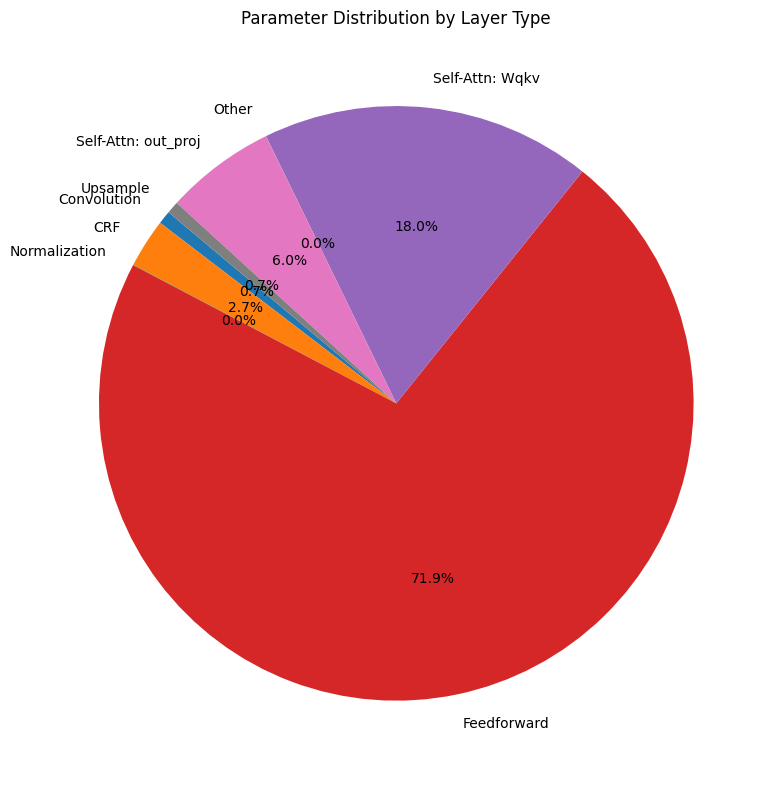

In [2]:
import os
import torch
from collections import defaultdict
import matplotlib.pyplot as plt

# Categorize based on filename
def categorize_layer(fname):
  if "conv" in fname:
    return "Convolution"
  elif "ff.fc1" in fname or "ff.fc2" in fname:
    return "Feedforward"
  elif "Wqkv" in fname:
    return "Self-Attn: Wqkv"
  elif "out_proj.weight" in fname:
    return "Self-Attn: out_proj"
  elif "crf.linear" in fname:
    return "CRF"
  elif "upsample" in fname:
    return "Upsample"
  elif "norm" in fname:
    return "Normalization"
  elif "deepnorm" in fname:
    return "DeepNorm"
  else:
    return "Other"

def summarize_layers(model_dir):
  stats = defaultdict(lambda: {"layers": 0, "params": 0})
  total_params = 0

  for fname in sorted(os.listdir(model_dir)):
    if not fname.endswith(".tensor"):
      continue

    fpath = os.path.join(model_dir, fname)
    try:
      mod = torch.jit.load(fpath)
      state = mod.state_dict()
      if len(state) != 1:
        continue
      _, tensor = next(iter(state.items()))
      num_params = tensor.numel()
      category = categorize_layer(fname)

      stats[category]["layers"] += 1
      stats[category]["params"] += num_params
      total_params += num_params

    except Exception as e:
      print(f"Error reading {fname}: {e}")

  return stats, total_params

def print_markdown_table(stats, total_params):
  print("| Layer Type | # Layers | # Parameters | % of Total |")
  print("|------------|----------|---------------|-------------|")
  for layer_type, data in sorted(stats.items(), key=lambda x: x[1]["params"], reverse=True):
    pct = 100 * data["params"] / total_params
    print(f"| {layer_type} | {data['layers']} | {data['params']:,} | {pct:.2f}% |")
  print(f"\n**Total Parameters**: `{total_params:,}`")

def plot_pie_chart(stats):
  labels = []
  sizes = []
  for layer_type, data in stats.items():
    if data["params"] > 0:
      labels.append(layer_type)
      sizes.append(data["params"])
  plt.figure(figsize=(8, 8))
  plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
  plt.title("Parameter Distribution by Layer Type")
  plt.tight_layout()
  plt.savefig("sup_model_layer_pie.png")
  plt.show()

# Run
model_dir = "/vol/bitbucket/bl1821/dorado-1.0.0-linux-x64/bin/dna_r10.4.1_e8.2_400bps_sup@v5.0.0"
stats, total = summarize_layers(model_dir)
print_markdown_table(stats, total)
plot_pie_chart(stats)


| Layer Type | # Layers | # Parameters | % of Total |
|------------|----------|--------------|-------------|
| Feedforward | 36 | 56,623,104 | 71.93% |
| Self-Attention | 54 | 18,883,584 | 23.99% |
| CRF | 1 | 2,097,152 | 2.66% |
| Convolution | 10 | 570,560 | 0.72% |
| Upsample | 2 | 525,312 | 0.67% |
| Other | 54 | 18,450 | 0.02% |

**Total Parameters:** `78,718,162`

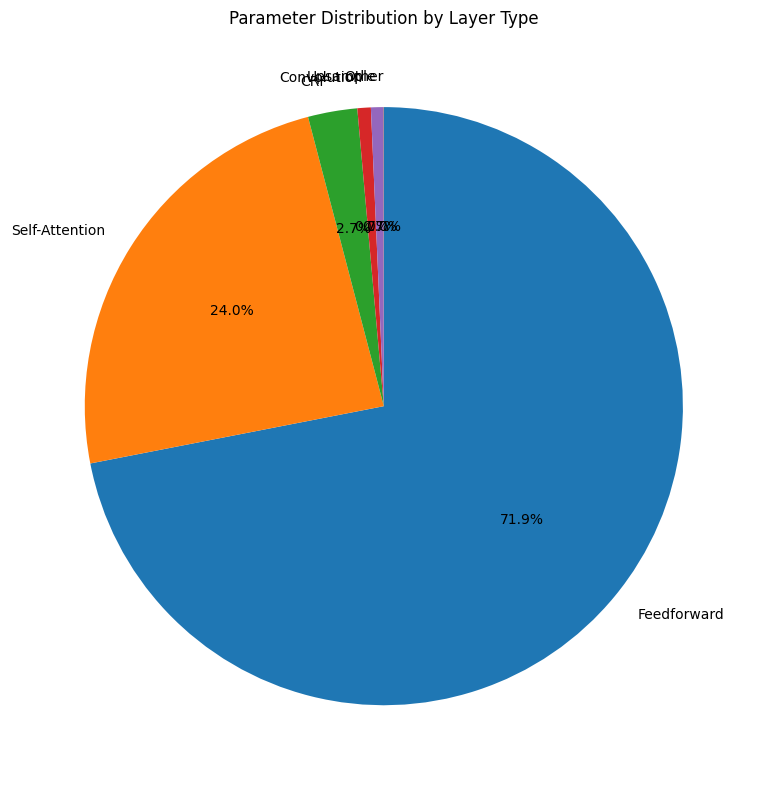

In [5]:
import os
import torch
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

def categorize_tensor_file(fname):
  if fname.startswith("conv."):
    return "Convolution"
  elif "self_attn.Wqkv" in fname or "self_attn.out_proj" in fname:
    return "Self-Attention"
  elif "ff.fc" in fname:
    return "Feedforward"
  elif fname.startswith("upsample."):
    return "Upsample"
  elif fname.startswith("crf."):
    return "CRF"
  elif "norm" in fname or "deepnorm" in fname or "bias" in fname:
    return "Other"
  else:
    return "Unclassified"

def summarize_model_by_layer_type(model_dir):
  layer_summary = defaultdict(lambda: {"layers": 0, "params": 0})

  for fname in sorted(os.listdir(model_dir)):
    if not fname.endswith(".tensor"):
      continue

    fpath = os.path.join(model_dir, fname)
    try:
      mod = torch.jit.load(fpath)
      state = mod.state_dict()
      if len(state) != 1:
        continue

      name, tensor = next(iter(state.items()))
      size = tensor.numel()
      layer_type = categorize_tensor_file(fname)

      layer_summary[layer_type]["layers"] += 1
      layer_summary[layer_type]["params"] += size

    except Exception as e:
      print(f"Failed to load {fname}: {e}")

  total_params = sum(v["params"] for v in layer_summary.values())

  # Build markdown table
  md = "| Layer Type | # Layers | # Parameters | % of Total |\n"
  md += "|------------|----------|--------------|-------------|\n"
  for layer, stats in sorted(layer_summary.items(), key=lambda x: x[1]["params"], reverse=True):
    pct = 100 * stats["params"] / total_params
    md += f"| {layer} | {stats['layers']} | {stats['params']:,} | {pct:.2f}% |\n"

  md += f"\n**Total Parameters:** `{total_params:,}`"
  display(Markdown(md))

  return layer_summary

def plot_pie_chart(layer_summary):
  labels = []
  sizes = []

  for layer_type, stats in sorted(layer_summary.items(), key=lambda x: x[1]["params"], reverse=True):
    labels.append(layer_type)
    sizes.append(stats["params"])

  plt.figure(figsize=(8, 8))
  plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90, counterclock=False)
  plt.title("Parameter Distribution by Layer Type")
  plt.tight_layout()
  plt.show()

# Usage
source_dir = "/vol/bitbucket/bl1821/dorado-1.0.0-linux-x64/bin/dna_r10.4.1_e8.2_400bps_sup@v5.0.0"
summary = summarize_model_by_layer_type(source_dir)
plot_pie_chart(summary)
